## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [48]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [49]:
train, test = keras.datasets.cifar10.load_data()

In [50]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [51]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [52]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [53]:
## 超參數設定
LEARNING_RATE = [1e-3]
EPOCHS = 100
BATCH_SIZE = 1024
MOMENTUM = 0.95
factors=[0.1,0.5,0.9]
patiences=[5,10,20]

In [54]:
"""
# 載入 Callbacks, 並設定監控目標為 validation loss
"""
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [55]:
results = {}
optimizer = {}
for lr in LEARNING_RATE:
    exp_name_tag = "Adam_exp-lr-%s" % str(lr)
    optimizer[exp_name_tag]={'optimizer':(keras.optimizers.Adam(lr=lr))}
    #exp_name_tag = "SGD_exp-lr-%s" % str(lr)
    #optimizer[exp_name_tag]={'optimizer':keras.optimizers.SGD(lr=lr)}
    exp_name_tag = "RMS_exp-lr-%s" % str(lr)
    optimizer[exp_name_tag]={'optimizer':keras.optimizers.RMSprop(lr=lr)}
    exp_name_tag = "AdaGrad_exp-lr-%s" % str(lr)
    optimizer[exp_name_tag]={'optimizer':keras.optimizers.Adagrad(lr=lr)}

for i,opt in enumerate(optimizer.keys()):
    for fs in list(factors):
        for ps in list(patiences):
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer[opt]['optimizer'])
            model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[ReduceLROnPlateau(factor=fs, 
                                      min_lr=1e-12, 
                                      monitor='val_loss', 
                                      patience=ps, 
                                      verbose=1)]
                 )
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["acc"]
            valid_acc = model.history.history["val_acc"]
            
            result_keys=list(optimizer.keys())[i]+"_factors_"+str(fs)+"_patience_"+str(ps)
            results[result_keys] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}
    

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 157us/step - loss: 0.0280 - acc: 0.9918 - val_loss: 3.8689 - val_acc: 0.4954
Epoch 2/100
50000/50000 [==============================] - 4s 89us/step - loss: 0.0174 - acc: 0.9960 - val_loss: 3.9477 - val_acc: 0.5033
Epoch 3/100
50000/50000 [==============================] - 5s 100us/step - loss: 0.0118 - acc: 0.9981 - val_loss: 3.8850 - val_acc: 0.5086
Epoch 4/100
50000/50000 [==============================] - 5s 99us/step - loss: 0.0102 - acc: 0.9986 - val_loss: 3.9493 - val_acc: 0.5032
Epoch 5/100
50000/50000 [==============================] - 5s 104us/step - loss: 0.0104 - acc: 0.9981 - val_loss: 4.0124 - val_acc: 0.5011
Epoch 6/100
50000/50000 [==============================] - 5s 102us/step - loss: 0.0185 - acc: 0.9951 - val_loss: 4.2364 - val_acc: 0.4789

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
50000/50000 [===========

50000/50000 [==============================] - 5s 91us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 3.7737 - val_acc: 0.5263

Epoch 00054: ReduceLROnPlateau reducing learning rate to 1e-12.
Epoch 55/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5264
Epoch 56/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5263
Epoch 57/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7739 - val_acc: 0.5262
Epoch 58/100
50000/50000 [==============================] - 5s 98us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5263
Epoch 59/100
50000/50000 [==============================] - 5s 99us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5264
Epoch 60/100
50000/50000 [==============================] - 5s 98us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 

50000/50000 [==============================] - 4s 88us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5260
Epoch 13/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7738 - val_acc: 0.5261
Epoch 14/100
50000/50000 [==============================] - 5s 98us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5263
Epoch 15/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5261
Epoch 16/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5263
Epoch 17/100
50000/50000 [==============================] - 5s 97us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7744 - val_acc: 0.5264
Epoch 18/100
50000/50000 [==============================] - 5s 94us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5263
Epoch 19/100
50000/50000 [==============

50000/50000 [==============================] - 5s 96us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5263
Epoch 72/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5262
Epoch 73/100
50000/50000 [==============================] - 5s 97us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5264
Epoch 74/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5265
Epoch 75/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5266
Epoch 76/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5263
Epoch 77/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5264
Epoch 78/100
50000/50000 [==============

Epoch 30/100
50000/50000 [==============================] - 5s 96us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7738 - val_acc: 0.5262
Epoch 31/100
50000/50000 [==============================] - 5s 94us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7738 - val_acc: 0.5264
Epoch 32/100
50000/50000 [==============================] - 5s 98us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7738 - val_acc: 0.5261
Epoch 33/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5262
Epoch 34/100
50000/50000 [==============================] - 5s 100us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7739 - val_acc: 0.5260
Epoch 35/100
50000/50000 [==============================] - 5s 94us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7738 - val_acc: 0.5260
Epoch 36/100
50000/50000 [==============================] - 5s 96us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7739 - val_acc: 0.5261
Epoch 37/100
50000/50000 [

Epoch 89/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5262
Epoch 90/100
50000/50000 [==============================] - 4s 87us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5264
Epoch 91/100
50000/50000 [==============================] - 4s 89us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5266
Epoch 92/100
50000/50000 [==============================] - 5s 98us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7739 - val_acc: 0.5264
Epoch 93/100
50000/50000 [==============================] - 5s 97us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5263
Epoch 94/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5263
Epoch 95/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7744 - val_acc: 0.5263
Epoch 96/100
50000/50000 [=

50000/50000 [==============================] - 5s 91us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5263
Epoch 48/100
50000/50000 [==============================] - 4s 88us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5261
Epoch 49/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5261
Epoch 50/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5262
Epoch 51/100
50000/50000 [==============================] - 4s 89us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5263
Epoch 52/100
50000/50000 [==============================] - 5s 94us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5264
Epoch 53/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7745 - val_acc: 0.5264
Epoch 54/100
50000/50000 [==============

50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5264
Epoch 6/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5264
Epoch 7/100
50000/50000 [==============================] - 4s 90us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7744 - val_acc: 0.5265
Epoch 8/100
50000/50000 [==============================] - 4s 90us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5261
Epoch 9/100
50000/50000 [==============================] - 5s 98us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5263
Epoch 10/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5263
Epoch 11/100
50000/50000 [==============================] - 5s 97us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5262
Epoch 12/100
50000/50000 [==================

50000/50000 [==============================] - 5s 93us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5260
Epoch 65/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5261
Epoch 66/100
50000/50000 [==============================] - 4s 87us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7744 - val_acc: 0.5261
Epoch 67/100
50000/50000 [==============================] - 5s 96us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5260
Epoch 68/100
50000/50000 [==============================] - 5s 95us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5261
Epoch 69/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5262
Epoch 70/100
50000/50000 [==============================] - 5s 95us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7744 - val_acc: 0.5262
Epoch 71/100
50000/50000 [==============

Epoch 23/100
50000/50000 [==============================] - 5s 98us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7738 - val_acc: 0.5264
Epoch 24/100
50000/50000 [==============================] - 5s 95us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7739 - val_acc: 0.5264
Epoch 25/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5264
Epoch 26/100
50000/50000 [==============================] - 5s 95us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7744 - val_acc: 0.5263
Epoch 27/100
50000/50000 [==============================] - 5s 96us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5261
Epoch 28/100
50000/50000 [==============================] - 4s 90us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5264
Epoch 29/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5262
Epoch 30/100
50000/50000 [=

Epoch 82/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5262
Epoch 83/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5261
Epoch 84/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5260
Epoch 85/100
50000/50000 [==============================] - 5s 94us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5264
Epoch 86/100
50000/50000 [==============================] - 5s 95us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5263
Epoch 87/100
50000/50000 [==============================] - 4s 90us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5261
Epoch 88/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5261
Epoch 89/100
50000/50000 [=

50000/50000 [==============================] - 5s 95us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5263
Epoch 41/100
50000/50000 [==============================] - 4s 88us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5261
Epoch 42/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5260
Epoch 43/100
50000/50000 [==============================] - 5s 95us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5260
Epoch 44/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7739 - val_acc: 0.5260
Epoch 45/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5261
Epoch 46/100
50000/50000 [==============================] - 5s 97us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5264
Epoch 47/100
50000/50000 [==============

50000/50000 [==============================] - 5s 99us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7739 - val_acc: 0.5260
Epoch 100/100
50000/50000 [==============================] - 5s 97us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5262
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 168us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5263
Epoch 2/100
50000/50000 [==============================] - 5s 94us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7739 - val_acc: 0.5264
Epoch 3/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7739 - val_acc: 0.5262
Epoch 4/100
50000/50000 [==============================] - 5s 94us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7739 - val_acc: 0.5263
Epoch 5/100
50000/50000 [==============================] - 5s 90us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 

Epoch 58/100
50000/50000 [==============================] - 5s 90us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5263
Epoch 59/100
50000/50000 [==============================] - 5s 90us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5261
Epoch 60/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5259
Epoch 61/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7739 - val_acc: 0.5263
Epoch 62/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7738 - val_acc: 0.5261
Epoch 63/100
50000/50000 [==============================] - 5s 96us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7739 - val_acc: 0.5263
Epoch 64/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5263
Epoch 65/100
50000/50000 [=

50000/50000 [==============================] - 5s 94us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5262
Epoch 17/100
50000/50000 [==============================] - 4s 89us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5263
Epoch 18/100
50000/50000 [==============================] - 4s 90us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5264
Epoch 19/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5261
Epoch 20/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5261
Epoch 21/100
50000/50000 [==============================] - 5s 92us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5265
Epoch 22/100
50000/50000 [==============================] - 5s 98us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5262
Epoch 23/100
50000/50000 [==============

50000/50000 [==============================] - 5s 92us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5262
Epoch 76/100
50000/50000 [==============================] - 5s 90us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 3.7742 - val_acc: 0.5262
Epoch 77/100
50000/50000 [==============================] - 5s 93us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7740 - val_acc: 0.5264
Epoch 78/100
50000/50000 [==============================] - 5s 96us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5265
Epoch 79/100
50000/50000 [==============================] - 5s 103us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7741 - val_acc: 0.5262
Epoch 80/100
50000/50000 [==============================] - 5s 94us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5264
Epoch 81/100
50000/50000 [==============================] - 5s 91us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 3.7743 - val_acc: 0.5263
Epoch 82/100
50000/50000 [=============

50000/50000 [==============================] - 5s 91us/step - loss: 8.2286e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5257
Epoch 32/100
50000/50000 [==============================] - 5s 95us/step - loss: 8.2602e-04 - acc: 1.0000 - val_loss: 3.9209 - val_acc: 0.5259

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 33/100
50000/50000 [==============================] - 4s 89us/step - loss: 8.1707e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5260
Epoch 34/100
50000/50000 [==============================] - 5s 96us/step - loss: 8.3420e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5257
Epoch 35/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.1773e-04 - acc: 1.0000 - val_loss: 3.9209 - val_acc: 0.5261
Epoch 36/100
50000/50000 [==============================] - 4s 90us/step - loss: 8.2617e-04 - acc: 1.0000 - val_loss: 3.9209 - val_acc: 0.5258
Epoch 37/100
50000/50000 [==============================] - 5s 96us/step -

50000/50000 [==============================] - 5s 95us/step - loss: 8.1758e-04 - acc: 1.0000 - val_loss: 3.9209 - val_acc: 0.5259
Epoch 86/100
50000/50000 [==============================] - 4s 87us/step - loss: 8.2538e-04 - acc: 1.0000 - val_loss: 3.9209 - val_acc: 0.5258
Epoch 87/100
50000/50000 [==============================] - 4s 90us/step - loss: 8.2272e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5255
Epoch 88/100
50000/50000 [==============================] - 5s 90us/step - loss: 8.3767e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5255
Epoch 89/100
50000/50000 [==============================] - 4s 87us/step - loss: 8.3690e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5259
Epoch 90/100
50000/50000 [==============================] - 5s 96us/step - loss: 8.0553e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5261
Epoch 91/100
50000/50000 [==============================] - 4s 90us/step - loss: 8.5697e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5260
Epoch 92/100

50000/50000 [==============================] - 5s 90us/step - loss: 8.3323e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5259
Epoch 43/100
50000/50000 [==============================] - 5s 95us/step - loss: 8.4617e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5262
Epoch 44/100
50000/50000 [==============================] - 4s 86us/step - loss: 8.2894e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5260
Epoch 45/100
50000/50000 [==============================] - 5s 92us/step - loss: 8.3697e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5262
Epoch 46/100
50000/50000 [==============================] - 4s 88us/step - loss: 8.1205e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5260
Epoch 47/100
50000/50000 [==============================] - 5s 95us/step - loss: 8.2291e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5260
Epoch 48/100
50000/50000 [==============================] - 5s 94us/step - loss: 8.1531e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5263
Epoch 49/100

50000/50000 [==============================] - 5s 91us/step - loss: 8.2394e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5258
Epoch 100/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.1419e-04 - acc: 1.0000 - val_loss: 3.9209 - val_acc: 0.5260
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 176us/step - loss: 8.2524e-04 - acc: 1.0000 - val_loss: 3.9209 - val_acc: 0.5259
Epoch 2/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.3081e-04 - acc: 1.0000 - val_loss: 3.9208 - val_acc: 0.5260
Epoch 3/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.4490e-04 - acc: 1.0000 - val_loss: 3.9209 - val_acc: 0.5258
Epoch 4/100
50000/50000 [==============================] - 4s 90us/step - loss: 8.0888e-04 - acc: 1.0000 - val_loss: 3.9206 - val_acc: 0.5257
Epoch 5/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.5300e-04 - acc: 1.0000 - 

50000/50000 [==============================] - 5s 97us/step - loss: 8.2483e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5258
Epoch 57/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.2364e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5260
Epoch 58/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.1685e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5261
Epoch 59/100
50000/50000 [==============================] - 4s 89us/step - loss: 8.2402e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5259
Epoch 60/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.2915e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5259
Epoch 61/100
50000/50000 [==============================] - 5s 90us/step - loss: 7.9101e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5260
Epoch 62/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.2551e-04 - acc: 1.0000 - val_loss: 3.9214 - val_acc: 0.5258
Epoch 63/100

50000/50000 [==============================] - 5s 95us/step - loss: 8.5084e-04 - acc: 1.0000 - val_loss: 3.9214 - val_acc: 0.5256
Epoch 14/100
50000/50000 [==============================] - 5s 95us/step - loss: 8.4431e-04 - acc: 1.0000 - val_loss: 3.9216 - val_acc: 0.5261
Epoch 15/100
50000/50000 [==============================] - 5s 95us/step - loss: 8.3429e-04 - acc: 1.0000 - val_loss: 3.9214 - val_acc: 0.5259
Epoch 16/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.8350e-04 - acc: 1.0000 - val_loss: 3.9214 - val_acc: 0.5260
Epoch 17/100
50000/50000 [==============================] - 4s 89us/step - loss: 8.0288e-04 - acc: 1.0000 - val_loss: 3.9214 - val_acc: 0.5260
Epoch 18/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.4134e-04 - acc: 1.0000 - val_loss: 3.9214 - val_acc: 0.5260
Epoch 19/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.2738e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5260
Epoch 20/100

50000/50000 [==============================] - 5s 92us/step - loss: 8.2837e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5261
Epoch 71/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.4848e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5262
Epoch 72/100
50000/50000 [==============================] - 5s 96us/step - loss: 8.2533e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5262
Epoch 73/100
50000/50000 [==============================] - 5s 90us/step - loss: 8.1400e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5260
Epoch 74/100
50000/50000 [==============================] - 4s 87us/step - loss: 8.2489e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5261
Epoch 75/100
50000/50000 [==============================] - 5s 92us/step - loss: 8.0431e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5260
Epoch 76/100
50000/50000 [==============================] - 5s 95us/step - loss: 8.2119e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5260
Epoch 77/100

50000/50000 [==============================] - 5s 95us/step - loss: 8.3495e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5257
Epoch 28/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.6977e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5260
Epoch 29/100
50000/50000 [==============================] - 4s 89us/step - loss: 8.3971e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5260
Epoch 30/100
50000/50000 [==============================] - 4s 87us/step - loss: 8.3957e-04 - acc: 1.0000 - val_loss: 3.9214 - val_acc: 0.5262
Epoch 31/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.2659e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5258
Epoch 32/100
50000/50000 [==============================] - 5s 92us/step - loss: 8.1575e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5260
Epoch 33/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.1064e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5260
Epoch 34/100

50000/50000 [==============================] - 5s 91us/step - loss: 8.3988e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5263
Epoch 85/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.1690e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5259
Epoch 86/100
50000/50000 [==============================] - 5s 94us/step - loss: 8.4548e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5257
Epoch 87/100
50000/50000 [==============================] - 5s 96us/step - loss: 8.6304e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5258
Epoch 88/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.2487e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5257
Epoch 89/100
50000/50000 [==============================] - 4s 87us/step - loss: 8.2974e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5259
Epoch 90/100
50000/50000 [==============================] - 5s 92us/step - loss: 8.2479e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5259
Epoch 91/100

50000/50000 [==============================] - 5s 91us/step - loss: 8.3924e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5256
Epoch 42/100
50000/50000 [==============================] - 5s 96us/step - loss: 8.4646e-04 - acc: 1.0000 - val_loss: 3.9208 - val_acc: 0.5257
Epoch 43/100
50000/50000 [==============================] - 5s 94us/step - loss: 8.6184e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5257
Epoch 44/100
50000/50000 [==============================] - 5s 92us/step - loss: 8.0316e-04 - acc: 1.0000 - val_loss: 3.9209 - val_acc: 0.5257
Epoch 45/100
50000/50000 [==============================] - 5s 90us/step - loss: 8.5638e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5258
Epoch 46/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.5236e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5257
Epoch 47/100
50000/50000 [==============================] - 5s 94us/step - loss: 8.0851e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5257
Epoch 48/100

50000/50000 [==============================] - 5s 93us/step - loss: 8.3323e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5257
Epoch 99/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.3553e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5253
Epoch 100/100
50000/50000 [==============================] - 5s 96us/step - loss: 7.9761e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5259
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 182us/step - loss: 8.3473e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5260
Epoch 2/100
50000/50000 [==============================] - 4s 89us/step - loss: 8.3296e-04 - acc: 1.0000 - val_loss: 3.9214 - val_acc: 0.5263
Epoch 3/100
50000/50000 [==============================] - 4s 90us/step - loss: 8.0441e-04 - acc: 1.0000 - val_loss: 3.9214 - val_acc: 0.5263
Epoch 4/100
50000/50000 [==============================] - 5s 92us/step - loss: 8.1468e-04 - acc: 1.0000 -

50000/50000 [==============================] - 5s 91us/step - loss: 8.3331e-04 - acc: 1.0000 - val_loss: 3.9214 - val_acc: 0.5260
Epoch 56/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.3112e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5261
Epoch 57/100
50000/50000 [==============================] - 5s 94us/step - loss: 8.4151e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5259
Epoch 58/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.3209e-04 - acc: 1.0000 - val_loss: 3.9209 - val_acc: 0.5262
Epoch 59/100
50000/50000 [==============================] - 4s 87us/step - loss: 8.1485e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5261
Epoch 60/100
50000/50000 [==============================] - 5s 92us/step - loss: 8.3429e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5264
Epoch 61/100
50000/50000 [==============================] - 5s 97us/step - loss: 8.1594e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5264
Epoch 62/100

50000/50000 [==============================] - 5s 95us/step - loss: 8.2272e-04 - acc: 1.0000 - val_loss: 3.9208 - val_acc: 0.5260
Epoch 13/100
50000/50000 [==============================] - 4s 90us/step - loss: 8.2677e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5261
Epoch 14/100
50000/50000 [==============================] - 4s 89us/step - loss: 8.4591e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5257
Epoch 15/100
50000/50000 [==============================] - 5s 96us/step - loss: 8.1301e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5261
Epoch 16/100
50000/50000 [==============================] - 5s 94us/step - loss: 8.4475e-04 - acc: 1.0000 - val_loss: 3.9213 - val_acc: 0.5262
Epoch 17/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.2460e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5256
Epoch 18/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.2971e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5259
Epoch 19/100

50000/50000 [==============================] - 5s 93us/step - loss: 8.3950e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5260
Epoch 70/100
50000/50000 [==============================] - 5s 90us/step - loss: 8.3715e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5261
Epoch 71/100
50000/50000 [==============================] - 4s 89us/step - loss: 8.5958e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5258
Epoch 72/100
50000/50000 [==============================] - 4s 89us/step - loss: 8.7364e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5258
Epoch 73/100
50000/50000 [==============================] - 5s 95us/step - loss: 8.3353e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5257
Epoch 74/100
50000/50000 [==============================] - 4s 88us/step - loss: 8.3541e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5260
Epoch 75/100
50000/50000 [==============================] - 4s 90us/step - loss: 8.3474e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5260
Epoch 76/100

50000/50000 [==============================] - 5s 95us/step - loss: 8.4787e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5260
Epoch 27/100
50000/50000 [==============================] - 5s 95us/step - loss: 7.8179e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5257
Epoch 28/100
50000/50000 [==============================] - 5s 91us/step - loss: 8.2430e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5257
Epoch 29/100
50000/50000 [==============================] - 5s 95us/step - loss: 8.4983e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5254
Epoch 30/100
50000/50000 [==============================] - 5s 97us/step - loss: 8.4542e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5259
Epoch 31/100
50000/50000 [==============================] - 4s 89us/step - loss: 8.2469e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5258
Epoch 32/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.5585e-04 - acc: 1.0000 - val_loss: 3.9212 - val_acc: 0.5262
Epoch 33/100

50000/50000 [==============================] - 5s 93us/step - loss: 8.3696e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5260
Epoch 84/100
50000/50000 [==============================] - 5s 93us/step - loss: 8.2850e-04 - acc: 1.0000 - val_loss: 3.9210 - val_acc: 0.5261
Epoch 85/100
50000/50000 [==============================] - 5s 95us/step - loss: 8.3984e-04 - acc: 1.0000 - val_loss: 3.9209 - val_acc: 0.5260
Epoch 86/100
50000/50000 [==============================] - 4s 90us/step - loss: 8.4926e-04 - acc: 1.0000 - val_loss: 3.9209 - val_acc: 0.5261
Epoch 87/100
50000/50000 [==============================] - 5s 94us/step - loss: 8.3220e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5263
Epoch 88/100
50000/50000 [==============================] - 5s 95us/step - loss: 8.2289e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5261
Epoch 89/100
50000/50000 [==============================] - 5s 94us/step - loss: 8.3692e-04 - acc: 1.0000 - val_loss: 3.9211 - val_acc: 0.5261
Epoch 90/100

50000/50000 [==============================] - 5s 94us/step - loss: 6.5521e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5258
Epoch 37/100
50000/50000 [==============================] - 5s 95us/step - loss: 6.2130e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5258
Epoch 38/100
50000/50000 [==============================] - 5s 93us/step - loss: 6.2662e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5257
Epoch 39/100
50000/50000 [==============================] - 5s 91us/step - loss: 6.4378e-04 - acc: 1.0000 - val_loss: 3.9625 - val_acc: 0.5257

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 40/100
50000/50000 [==============================] - 5s 98us/step - loss: 6.6658e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5258
Epoch 41/100
50000/50000 [==============================] - 5s 92us/step - loss: 6.4343e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5258
Epoch 42/100
50000/50000 [==============================] - 4s 86us/step -

50000/50000 [==============================] - 5s 97us/step - loss: 6.4419e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5261
Epoch 92/100
50000/50000 [==============================] - 4s 90us/step - loss: 6.2776e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5258
Epoch 93/100
50000/50000 [==============================] - 4s 87us/step - loss: 6.4750e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5258
Epoch 94/100
50000/50000 [==============================] - 5s 94us/step - loss: 6.3563e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5258
Epoch 95/100
50000/50000 [==============================] - 5s 95us/step - loss: 6.2716e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5258
Epoch 96/100
50000/50000 [==============================] - 4s 86us/step - loss: 6.4834e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5259
Epoch 97/100
50000/50000 [==============================] - 5s 94us/step - loss: 6.4973e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5258
Epoch 98/100

50000/50000 [==============================] - 5s 91us/step - loss: 6.3496e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5259
Epoch 49/100
50000/50000 [==============================] - 5s 91us/step - loss: 6.3517e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5259
Epoch 50/100
50000/50000 [==============================] - 4s 86us/step - loss: 6.4808e-04 - acc: 1.0000 - val_loss: 3.9627 - val_acc: 0.5259
Epoch 51/100
50000/50000 [==============================] - 5s 92us/step - loss: 6.7546e-04 - acc: 1.0000 - val_loss: 3.9625 - val_acc: 0.5260
Epoch 52/100
50000/50000 [==============================] - 4s 90us/step - loss: 6.4711e-04 - acc: 1.0000 - val_loss: 3.9625 - val_acc: 0.5256
Epoch 53/100
50000/50000 [==============================] - 5s 94us/step - loss: 6.5575e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5258
Epoch 54/100
50000/50000 [==============================] - 5s 92us/step - loss: 6.3992e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5257
Epoch 55/100

50000/50000 [==============================] - 5s 98us/step - loss: 6.2906e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5257
Epoch 6/100
50000/50000 [==============================] - 4s 87us/step - loss: 6.5959e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5259
Epoch 7/100
50000/50000 [==============================] - 4s 89us/step - loss: 6.5315e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5258
Epoch 8/100
50000/50000 [==============================] - 5s 90us/step - loss: 6.4956e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5256
Epoch 9/100
50000/50000 [==============================] - 4s 87us/step - loss: 6.4184e-04 - acc: 1.0000 - val_loss: 3.9619 - val_acc: 0.5256
Epoch 10/100
50000/50000 [==============================] - 4s 86us/step - loss: 6.5206e-04 - acc: 1.0000 - val_loss: 3.9619 - val_acc: 0.5257
Epoch 11/100
50000/50000 [==============================] - 5s 92us/step - loss: 6.3188e-04 - acc: 1.0000 - val_loss: 3.9617 - val_acc: 0.5257
Epoch 12/100
500

50000/50000 [==============================] - 5s 91us/step - loss: 6.2536e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5260
Epoch 63/100
50000/50000 [==============================] - 5s 95us/step - loss: 6.3119e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5260
Epoch 64/100
50000/50000 [==============================] - 4s 89us/step - loss: 6.4952e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5258
Epoch 65/100
50000/50000 [==============================] - 5s 96us/step - loss: 6.3989e-04 - acc: 1.0000 - val_loss: 3.9620 - val_acc: 0.5258
Epoch 66/100
50000/50000 [==============================] - 4s 90us/step - loss: 6.4599e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5257
Epoch 67/100
50000/50000 [==============================] - 5s 91us/step - loss: 6.4871e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5256
Epoch 68/100
50000/50000 [==============================] - 5s 91us/step - loss: 6.4895e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5254
Epoch 69/100

50000/50000 [==============================] - 4s 90us/step - loss: 6.3612e-04 - acc: 1.0000 - val_loss: 3.9620 - val_acc: 0.5257
Epoch 20/100
50000/50000 [==============================] - 5s 93us/step - loss: 6.1488e-04 - acc: 1.0000 - val_loss: 3.9620 - val_acc: 0.5258
Epoch 21/100
50000/50000 [==============================] - 4s 88us/step - loss: 6.4316e-04 - acc: 1.0000 - val_loss: 3.9618 - val_acc: 0.5259
Epoch 22/100
50000/50000 [==============================] - 5s 92us/step - loss: 6.2106e-04 - acc: 1.0000 - val_loss: 3.9619 - val_acc: 0.5258
Epoch 23/100
50000/50000 [==============================] - 5s 92us/step - loss: 6.2232e-04 - acc: 1.0000 - val_loss: 3.9619 - val_acc: 0.5259
Epoch 24/100
50000/50000 [==============================] - 5s 91us/step - loss: 6.4381e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5257
Epoch 25/100
50000/50000 [==============================] - 5s 90us/step - loss: 6.3414e-04 - acc: 1.0000 - val_loss: 3.9620 - val_acc: 0.5258
Epoch 26/100

50000/50000 [==============================] - 5s 92us/step - loss: 6.5569e-04 - acc: 1.0000 - val_loss: 3.9619 - val_acc: 0.5257
Epoch 77/100
50000/50000 [==============================] - 4s 89us/step - loss: 6.5326e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5258
Epoch 78/100
50000/50000 [==============================] - 4s 87us/step - loss: 6.3939e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5259
Epoch 79/100
50000/50000 [==============================] - 5s 92us/step - loss: 6.4204e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5256
Epoch 80/100
50000/50000 [==============================] - 4s 90us/step - loss: 6.3323e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5257
Epoch 81/100
50000/50000 [==============================] - 5s 96us/step - loss: 6.3062e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5258
Epoch 82/100
50000/50000 [==============================] - 5s 90us/step - loss: 6.4682e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5259
Epoch 83/100

50000/50000 [==============================] - 4s 88us/step - loss: 6.2951e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5257
Epoch 34/100
50000/50000 [==============================] - 4s 89us/step - loss: 6.4349e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5257
Epoch 35/100
50000/50000 [==============================] - 4s 86us/step - loss: 6.4979e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5257
Epoch 36/100
50000/50000 [==============================] - 5s 96us/step - loss: 6.6670e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5258
Epoch 37/100
50000/50000 [==============================] - 5s 94us/step - loss: 6.3222e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5257
Epoch 38/100
50000/50000 [==============================] - 5s 94us/step - loss: 6.5769e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5258
Epoch 39/100
50000/50000 [==============================] - 5s 92us/step - loss: 6.4153e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5259
Epoch 40/100

50000/50000 [==============================] - 5s 92us/step - loss: 6.2335e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5258
Epoch 91/100
50000/50000 [==============================] - 5s 96us/step - loss: 6.3488e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5260
Epoch 92/100
50000/50000 [==============================] - 4s 89us/step - loss: 6.5585e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5258
Epoch 93/100
50000/50000 [==============================] - 5s 90us/step - loss: 6.4278e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5260
Epoch 94/100
50000/50000 [==============================] - 5s 91us/step - loss: 6.4484e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5258
Epoch 95/100
50000/50000 [==============================] - 4s 88us/step - loss: 6.2641e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5257
Epoch 96/100
50000/50000 [==============================] - 5s 92us/step - loss: 6.5403e-04 - acc: 1.0000 - val_loss: 3.9625 - val_acc: 0.5256
Epoch 97/100

50000/50000 [==============================] - 5s 94us/step - loss: 6.5496e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5257
Epoch 48/100
50000/50000 [==============================] - 4s 90us/step - loss: 6.2078e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5258
Epoch 49/100
50000/50000 [==============================] - 5s 94us/step - loss: 6.3449e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5256
Epoch 50/100
50000/50000 [==============================] - 4s 89us/step - loss: 6.3216e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5256
Epoch 51/100
50000/50000 [==============================] - 5s 91us/step - loss: 6.3524e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5255
Epoch 52/100
50000/50000 [==============================] - 5s 91us/step - loss: 6.3182e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5257
Epoch 53/100
50000/50000 [==============================] - 4s 89us/step - loss: 6.1183e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5257
Epoch 54/100

50000/50000 [==============================] - 4s 86us/step - loss: 6.3063e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5258
Epoch 5/100
50000/50000 [==============================] - 5s 94us/step - loss: 6.3474e-04 - acc: 1.0000 - val_loss: 3.9620 - val_acc: 0.5256
Epoch 6/100
50000/50000 [==============================] - 4s 89us/step - loss: 6.3227e-04 - acc: 1.0000 - val_loss: 3.9620 - val_acc: 0.5258
Epoch 7/100
50000/50000 [==============================] - 4s 86us/step - loss: 6.6124e-04 - acc: 1.0000 - val_loss: 3.9619 - val_acc: 0.5257
Epoch 8/100
50000/50000 [==============================] - 5s 92us/step - loss: 6.4085e-04 - acc: 1.0000 - val_loss: 3.9618 - val_acc: 0.5258
Epoch 9/100
50000/50000 [==============================] - 4s 90us/step - loss: 6.5222e-04 - acc: 1.0000 - val_loss: 3.9618 - val_acc: 0.5257
Epoch 10/100
50000/50000 [==============================] - 4s 87us/step - loss: 6.5099e-04 - acc: 1.0000 - val_loss: 3.9619 - val_acc: 0.5258
Epoch 11/100
5000

50000/50000 [==============================] - 5s 92us/step - loss: 6.3522e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5259
Epoch 62/100
50000/50000 [==============================] - 5s 94us/step - loss: 6.4132e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5260
Epoch 63/100
50000/50000 [==============================] - 4s 89us/step - loss: 6.3066e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5260
Epoch 64/100
50000/50000 [==============================] - 5s 94us/step - loss: 6.3203e-04 - acc: 1.0000 - val_loss: 3.9620 - val_acc: 0.5261
Epoch 65/100
50000/50000 [==============================] - 4s 90us/step - loss: 6.4646e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5259
Epoch 66/100
50000/50000 [==============================] - 4s 89us/step - loss: 6.3434e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5258
Epoch 67/100
50000/50000 [==============================] - 5s 95us/step - loss: 6.4430e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5256
Epoch 68/100

50000/50000 [==============================] - 4s 89us/step - loss: 6.4348e-04 - acc: 1.0000 - val_loss: 3.9626 - val_acc: 0.5258
Epoch 19/100
50000/50000 [==============================] - 4s 87us/step - loss: 6.2203e-04 - acc: 1.0000 - val_loss: 3.9625 - val_acc: 0.5256
Epoch 20/100
50000/50000 [==============================] - 5s 95us/step - loss: 6.5615e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5257
Epoch 21/100
50000/50000 [==============================] - 5s 91us/step - loss: 6.6851e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5259
Epoch 22/100
50000/50000 [==============================] - 4s 89us/step - loss: 6.2696e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5257
Epoch 23/100
50000/50000 [==============================] - 5s 92us/step - loss: 6.4846e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5258
Epoch 24/100
50000/50000 [==============================] - 5s 92us/step - loss: 6.5419e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5260
Epoch 25/100

50000/50000 [==============================] - 4s 81us/step - loss: 6.5062e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5257
Epoch 76/100
50000/50000 [==============================] - 4s 85us/step - loss: 6.2782e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5259
Epoch 77/100
50000/50000 [==============================] - 5s 91us/step - loss: 6.3741e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5257
Epoch 78/100
50000/50000 [==============================] - 4s 83us/step - loss: 6.2464e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5258
Epoch 79/100
50000/50000 [==============================] - 4s 80us/step - loss: 6.4975e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5259
Epoch 80/100
50000/50000 [==============================] - 4s 85us/step - loss: 6.3214e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5256
Epoch 81/100
50000/50000 [==============================] - 4s 83us/step - loss: 6.3033e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5258
Epoch 82/100

50000/50000 [==============================] - 4s 82us/step - loss: 6.3768e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5256
Epoch 33/100
50000/50000 [==============================] - 4s 89us/step - loss: 6.3981e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5259
Epoch 34/100
50000/50000 [==============================] - 4s 85us/step - loss: 6.4129e-04 - acc: 1.0000 - val_loss: 3.9620 - val_acc: 0.5260
Epoch 35/100
50000/50000 [==============================] - 4s 85us/step - loss: 6.3451e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5259
Epoch 36/100
50000/50000 [==============================] - 4s 86us/step - loss: 6.4722e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5260
Epoch 37/100
50000/50000 [==============================] - 4s 83us/step - loss: 6.3621e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5259
Epoch 38/100
50000/50000 [==============================] - 5s 91us/step - loss: 6.2791e-04 - acc: 1.0000 - val_loss: 3.9621 - val_acc: 0.5258
Epoch 39/100

50000/50000 [==============================] - 4s 87us/step - loss: 6.4012e-04 - acc: 1.0000 - val_loss: 3.9625 - val_acc: 0.5257
Epoch 90/100
50000/50000 [==============================] - 4s 87us/step - loss: 6.4607e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5256
Epoch 91/100
50000/50000 [==============================] - 4s 82us/step - loss: 6.4856e-04 - acc: 1.0000 - val_loss: 3.9624 - val_acc: 0.5259
Epoch 92/100
50000/50000 [==============================] - 4s 80us/step - loss: 6.2631e-04 - acc: 1.0000 - val_loss: 3.9623 - val_acc: 0.5257
Epoch 93/100
50000/50000 [==============================] - 4s 88us/step - loss: 6.2459e-04 - acc: 1.0000 - val_loss: 3.9622 - val_acc: 0.5256
Epoch 94/100
50000/50000 [==============================] - 4s 84us/step - loss: 6.2765e-04 - acc: 1.0000 - val_loss: 3.9619 - val_acc: 0.5257
Epoch 95/100
50000/50000 [==============================] - 4s 86us/step - loss: 6.4706e-04 - acc: 1.0000 - val_loss: 3.9620 - val_acc: 0.5256
Epoch 96/100

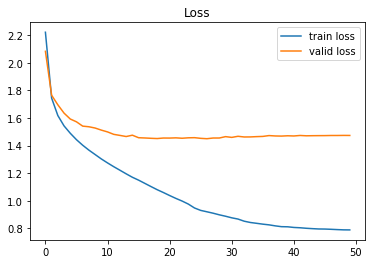

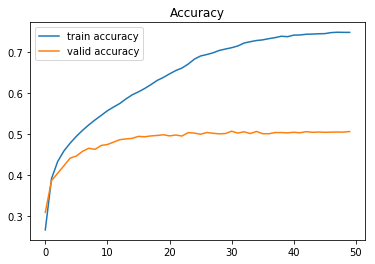

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k","w","c"]

print(results.keys())
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i%8])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i%8])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i%8])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i%8])
plt.title("Accuracy")
plt.legend()
plt.show()